The workflow for interrogating data for the presence of clusters is as follows:
 - Import the data into a Pandas dataframe
 - Format the data to contain just numerical columns for linkage matrix
 - Create the linkage matrix usign scipy and an appropriate HAC algorithm: Ward, complete, single, etc.
 - Visually inspect the dendrogram to idetify the best point to cut off the tree
 - Run the PCP function to test the fit of the clustering algorith at a chosen distance

In [1]:
import pandas as pd
import scipy as sp
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib import pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

In [2]:
%matplotlib inline
output_notebook()

Loading BokehJS ...

#### Step 1: import the Iris data and format as appropriate

In [3]:
orig_df = pd.read_csv('iris.csv')

num_df = orig_df.select_dtypes(exclude='object')

#### Step 2: create the linkage matrix

In [11]:
Z = linkage(num_df, 'ward')

#### Step 3: show a high-resolution dendrogram with the clusters

In [114]:
#adapted from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#for future: tweak plot.ly script to use the interactive dendrogram with zoom instead of static svg
#at the moment, the 'complete' algorithm is hard-coded into plot.ly dendrogram

def fancy_dendrogram(*args, **kwargs):
    """
    The two extra arguments that enhance the default dendrogram are:
        max_d - the point y at which to draw a horizontal guideline
        annotate_above - the minimum distance y for which to show annotations 
    """
    max_d = kwargs.pop('max_d', None) #max_d isn't a keyword argument in the original dendrogram function
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', None)
    
    plt.figure(dpi=400, figsize=(12,6))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if annotate_above != None:
                if y > annotate_above:
                    plt.plot(x, y, 'ob') #ob is blue circle
                    plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                                textcoords='offset points',
                                va='top', ha='center',
                                color='black')
        if max_d:
            plt.axhline(y=max_d, c='black', ls='dashed', alpha=1, aa=True,lw=0.5)
            num_clusters = fcluster(Z, max_d, criterion='distance').max()
            plt.annotate("Number of clusters at distance {} is: {}".format(max_d, num_clusters),
                        xy=(0,max_d+(max_d*0.1)), va='bottom', rotation=-90)
    return ddata

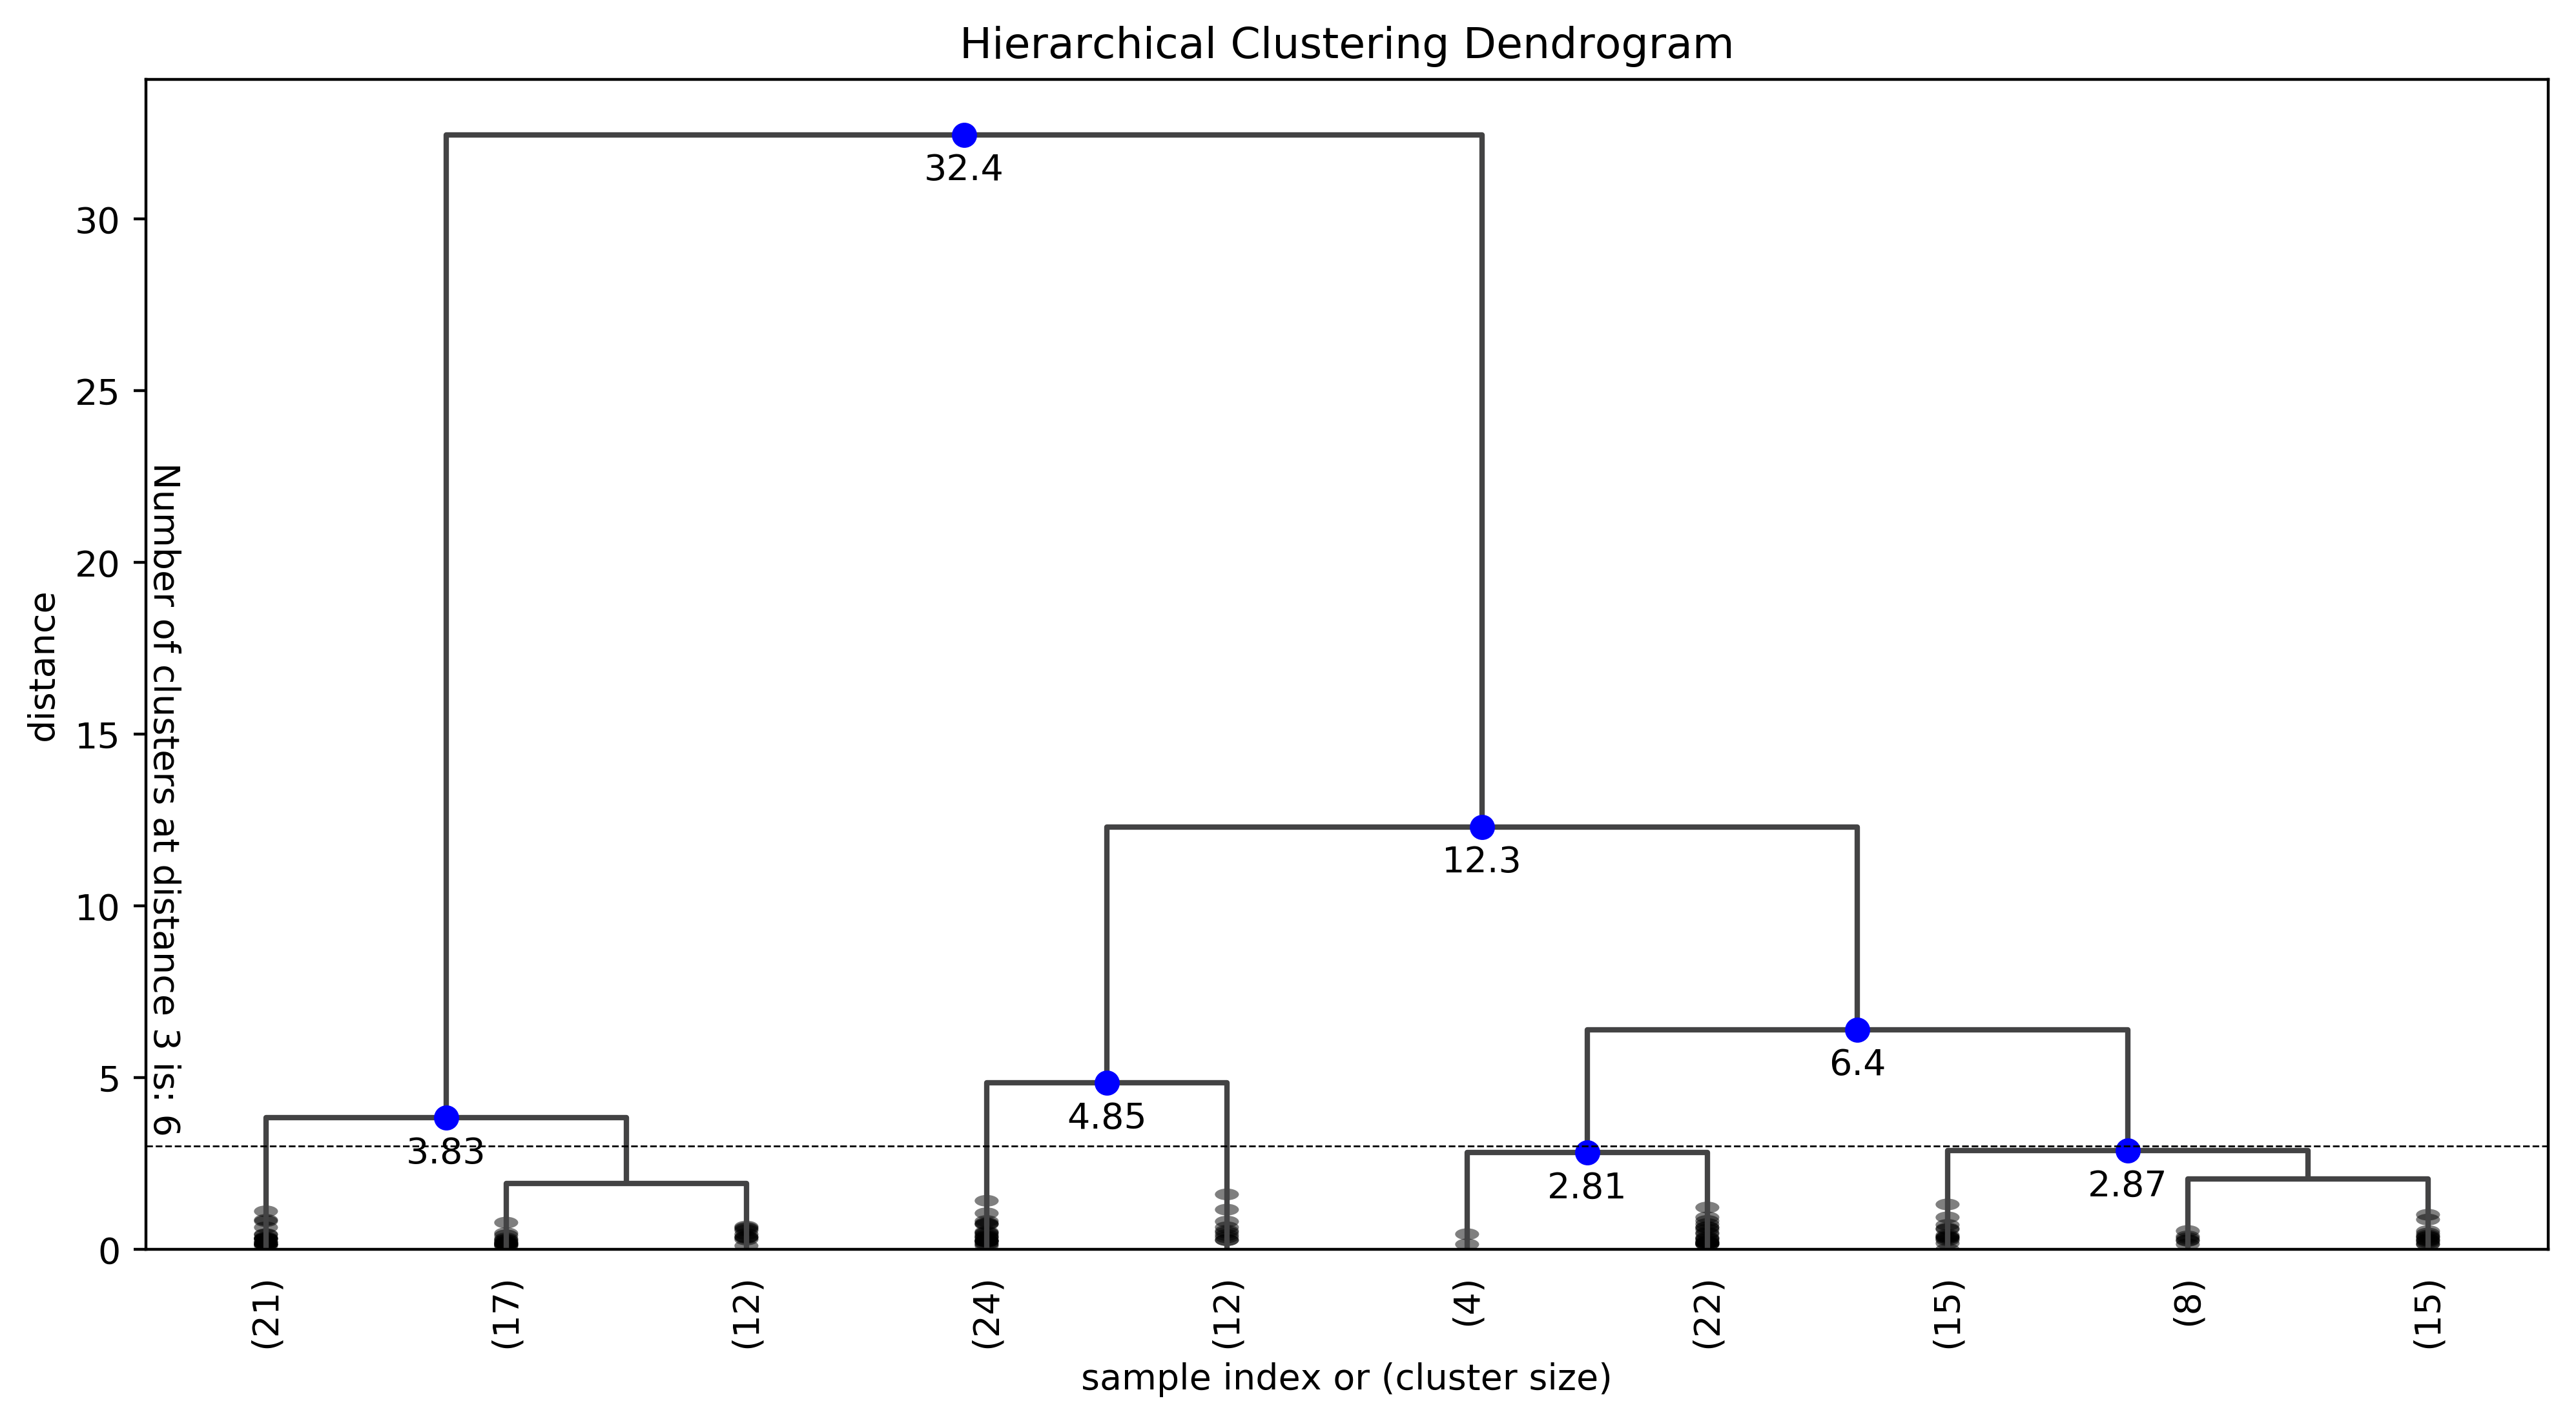

In [115]:
#inspect the dendrogram visually first, then uncomment the parameters to give more nuance

fancy_dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
    link_color_func=lambda x:'#434344',
    color_threshold=0,
    show_contracted=True,
    truncate_mode='lastp',
    p=10,
    annotate_above=2.5,
    max_d=3,
)
plt.savefig('dendogram.png')

#### Step 4: now that you know your distance and the number of clusters, see how they compare to the original data

In [158]:
def pcp(df, Z, max_d, **kwargs):
    """
    Parallel Coordinates Plot to visualise clusters within original dataset
    
    You need to provide the constructor with a few things:
        - df is the dataframe that you used for creating the linkage matrix
        - Z is the linkage matrix
        - max_d is the distance at which to cut the HAC dendrogram
    By default, the axes for the PCP will be taken from the column headers in DF;
    You can overwrite them by adding in an optional parameter 'domains=[]'. The 
    number of user-set domains must match the number of columns used to create the
    linkage matrix.
    """
    
    if 'domains' not in kwargs:
        domains = df.columns.values
    else:
        if (len(kwargs['domains']) == len(df.columns.values)):
            domains = kwargs['domains']
        else:
            raise ValueError('The number of domains passed is incorrect')
    
    num_aliases = list(range(len(domains)))
    
    def normalize(df):
        result = df.copy()
        for feature_name in df.columns:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result
    
    norm_df = normalize(df)
    
    #multiline doesn't work with categorical x-axis.
    p = figure(plot_width=800, plot_height=400, x_range=(0,len(domains)-1), y_range=(0,1))

    p.title.text = 'Parallel coordinates plot in Bokeh'
    p.title.align = 'center'

    #format x and y axis, including overwriting labels
    p.xaxis.ticker = num_aliases
    p.xaxis.major_label_overrides = dict(zip(num_aliases, domains))
    p.yaxis.axis_label = "Y-Axis"
    p.yaxis.minor_tick_line_color = None
    #p.yaxis.ticker = list(range(1,11)) #need to overwrite normalized values with originals!!!!
    #p.yaxis.major_label_overrides = dict(zip(list(range(1,11)),
                                            #['1 (Most Deprived)', '2', '3', '4','5',
                                            #'6', '7', '8', '9', '10 (Least Deprived)']))

    #create renderers
    p.segment(x0=num_aliases, y0=[0]*len(domains), x1=num_aliases,
              y1=[1]*len(domains), color="grey", line_width=2)

    p.multi_line(xs=[num_aliases]*len(df), ys=[list(row.values) for index, row in norm_df.iterrows()],
                 line_width=1, line_alpha=0.2)

    p.grid.visible = False

    show(p)    

In [159]:
pcp(num_df, Z, 3)

In [161]:
orig_df.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)